In [1]:
import json
import math
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
from scipy.interpolate import interp1d
from scipy.stats import pearsonr, mode
from scipy.signal import savgol_filter
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

addressPrefix='C:/Users/sorush.omidvar/Google Drive/Documents/Educational/TAMU/Research/CGM Dataset/Bobak/'
if not os.path.exists(addressPrefix):
    addressPrefix='C:/GDrive/Documents/Educational/TAMU/Research/CGM Dataset/Bobak/'
pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use({'figure.facecolor':'white'})

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Meal Format: Time, Carb, Fat, Protein to comply myfinesspal formating starting from Jan 31 til Feb 9
breakFast=[[31,'07-52-34',170,12,15],
[32,'07-09-13',170,12,60],
[33,'07-19-09',170,48,15],
[34,'06-47-38',170,12,15],
[35,'07-27-52',170,48,60],
[36,'07-18-46',42.5,12,15],
[37,'07-18-46',170,12,15],
[38,'07-44-07',170,12,60],
[39,'07-23-33',170,48,15],
[40,'06-50-00',170,12,15]]

lunch=[[31,'12-20-32',170,12,15],
[32,'12-19-09',170,12,60],
[33,'12-17-27',42.5,12,60],
[34,'12-11-35',170,12,60],
[35,'11-57-05',42.5,12,60],
[36,'12-35-21',170,48,60],
[37,'12-08-40',42.5,12,60],
[38,'11-22-23',170,12,15],
[39,'12-16-25',42.5,12,60],
[40,'12-12-34',170,48,15]]

dinner=[[31,'17-55-02',84,50,27],
[32,'17-21-14',49,28,41],
[33,'17-50-56',21,28,53],
[34,'17-45-17',70,35,39],
[35,'17-18-12',110,28,46],
[36,'17-41-39',53,51,67],
[37,'16-44-56',68,39,25],
[38,'15-58-07',71,52,82],
[39,'16-59-39',66,43,28],
[40,'17-44-56',122,47,51]]

mealData=[]
mealTemp=breakFast
mealTemp.extend(lunch)
mealTemp.extend(dinner)

for element in mealTemp:
    timeTemp = datetime.strptime(element[1], '%H-%M-%S')
    timeTemp=timeTemp.time()
    timeTemp=timeTemp.hour*3600+timeTemp.minute*60+timeTemp.second
    mealData.append([element[0],timeTemp,element[2],element[3],element[4]])

dfMacro=pd.DataFrame(data=mealData,columns=['Date','Time','Carb','Fat','Protein'])

In [3]:
def loadingDataReader(fileAddress,parameter):
    try:
        jsonFile = open(fileAddress, )
        data = json.load(jsonFile)

        dateList=[]
        timeList=[]
        valList=[]
        for i in data:
            for j in data[i]:
                timeTemp=j["time"]
                timeTemp=int(timeTemp[0:2])*3600+int(timeTemp[3:5])*60+int(timeTemp[6:8])
                timeList.append(timeTemp)

                dateTemp=i
                dateTemp = datetime.strptime(dateTemp, '%m-%d')+relativedelta(years=+121)
                dateTemp=dateTemp.timetuple().tm_yday
                dateList.append(dateTemp)
                valList.append(float(j["value"]))
        jsonFile.close()
    except:
        print("An exception occurred")

    parList = []
    for i in range (0,len(dateList)):
        parList.append(parameter)

    return dateList,timeList,valList,parList

def loadingDataAux(fileAddress,parameter,allDate,allTime,allVal,allPar):
    fileAddress=os.path.normpath(fileAddress)
    [tempDate,tempTime,tempVal,tempPar]=loadingDataReader(fileAddress,parameter)
    allDate.extend(tempDate)
    allTime.extend(tempTime)
    allVal.extend(tempVal)
    allPar.extend(tempPar)
    print(parameter," is done")

    return allDate,allTime,allVal,allPar

def dataResEnhancer(df):
    gapLength=1
    df=df.sort_values(by=['Parameter', 'Date','Time'])
    gapList=[]

    highResSensor=['Acc','EDA','HR','Temp','CGM','Step','Cal']
    for sensor in highResSensor:
        newQuery=df[df['Parameter']==sensor]
        for counter in range(0,len(newQuery)-1):
            if newQuery.iloc[counter+1,0]==newQuery.iloc[counter+1,0]:
                if newQuery.iloc[counter+1,1]-newQuery.iloc[counter,1]>gapLength:
                    gapList.append([newQuery.iloc[counter,0],newQuery.iloc[counter,1],newQuery.iloc[counter+1,1],newQuery.iloc[counter,3]])
    appendedData=[]
    for element in gapList:
        duration= element[2]-element[1]
        if duration%gapLength==0:
            fillerNumber=int(duration/gapLength-1)
        else:
            fillerNumber=int(duration/gapLength)
        for counter in range(0,fillerNumber):
            appendedData.append([element[0],element[1]+(counter+1)*gapLength,float('nan'),element[3]])

    df = df.append(pd.DataFrame(appendedData,columns=['Date','Time','Value','Parameter']),ignore_index = True)
    df=df.sort_values(by=['Parameter','Date','Time'])

    df=df.interpolate(method='linear')
    return df

def dataCleaner(df):
    i = df[df.Date == 30].index #first data and noisy
    df=df.drop(i)

    i = df[df.Date == 40].index #Partial E4
    df=df.drop(i)

    i = df[df.Date == 41].index #No E4
    df=df.drop(i)

    i = df[df.Date >= 42].index #CGM becomes too noisy at the end of the study
    df=df.drop(i)

    return df

def dataAmputator(df):
    amputations=[[31,38290,39010],[31,61937,62638],[31,66226,71099],
              [32,58667,59563],[32,63875,63902],
              [33,25127,34731],[33,57996,58812],
              [34,25556,30763],[34,58736,59877],[34,66069,66092],
              [35,27945,31416],[35,57283,58147],
              [36,29865,33926],[36,59231,60096],
              [37,26911,32544],[37,40214,41380],
              [38,26707,34560],[38,38172,39273],
              [39,31053,35335],[39,57408,58655]]

    for amputation in amputations:
        i=df[(df['Date']==amputation[0]) & (df['Time']>=amputation[1]) & (df['Time']<=amputation[2])].index
        df.loc[i,'Value']=float('nan')
        # df=df.drop(i)
    df=df.interpolate(method='linear')
    return df

def loadingData(addressPrefix):
    if not os.path.exists(addressPrefix+'Result-interpolated.csv'):
        allDate=[]
        allTime=[]
        allVal=[]
        allPar=[]

        sensorList=[['intraday-ACC_E4.json','Acc'],['intraday-calories.json','Cal'],
                    ['intraday-EDA_E4.json','EDA'],['intraday-HR_E4.json','HR'],
                    ['intraday-steps.json','Step'],['intraday-TEMP_E4.json','Temp'],
                    ['intraday-glucose.json','CGM']]

        for element in sensorList:
            fileAddress=addressPrefix+element[0]
            allDate,allTime,allVal,allPar=loadingDataAux(fileAddress,element[1],allDate,allTime,allVal,allPar)

        dfOriginal = pd.DataFrame(list(zip(allDate,allTime,allVal,allPar)),
                          columns =['Date','Time','Value','Parameter'])
        dfOriginal=dfOriginal.sort_values(by=['Parameter','Date','Time'])
        dfOriginal.to_csv(addressPrefix+'Result-original.csv', header=True,index=False)
        print("Result-Original is saved")
        dfInterp=dataCleaner(dfOriginal)
        dfInterp=dataResEnhancer(dfInterp)
        dfInterp=dataAmputator(dfInterp)
        dfInterp.to_csv(addressPrefix+'Result-interpolated.csv', header=True,index=False)
        print("Result-Interpolated is saved")
    else:
        dfOriginal=pd.read_csv(addressPrefix+'Result-original.csv')
        dfInterp=pd.read_csv(addressPrefix+'Result-interpolated.csv')
    return dfOriginal,dfInterp

dfOriginal,dfInterp=loadingData(addressPrefix)

Used features [['CGM', 'mean'], ['CGM', 'max'], ['CGM', 'var'], ['CGM', 'S-mean'], ['CGM', 'S-max'], ['CGM', 'S-min'], ['CGM', 'SS-mean'], ['CGM', 'trapz'], ['CGM', 'auc0'], ['CGM', 'auc1'], ['CGM', 'auc2'], ['CGM', 'auc3'], ['CGM', 'auc4'], ['CGM', 'auc5'], ['CGM', 'auc6'], ['CGM', 'auc7'], ['CGM', 'auc8'], ['CGM', 'auc0'], ['CGM', 'auc1'], ['CGM', 'auc2'], ['CGM', 'auc3'], ['CGM', 'auc4'], ['CGM', 'auc5'], ['EDA', 'mean'], ['EDA', 'max'], ['EDA', 'var'], ['EDA', 'S-mean'], ['EDA', 'S-max'], ['EDA', 'S-min'], ['EDA', 'SS-mean'], ['EDA', 'trapz'], ['Acc', 'mean'], ['Acc', 'max'], ['Acc', 'var'], ['Acc', 'S-mean'], ['Acc', 'S-max'], ['Acc', 'S-min'], ['Acc', 'SS-mean'], ['Acc', 'trapz'], ['Temp', 'mean'], ['Temp', 'max'], ['Temp', 'var'], ['Temp', 'S-mean'], ['Temp', 'S-max'], ['Temp', 'S-min'], ['Temp', 'SS-mean'], ['Temp', 'trapz'], ['HR', 'mean'], ['HR', 'max'], ['HR', 'var'], ['HR', 'S-mean'], ['HR', 'S-max'], ['HR', 'S-min'], ['HR', 'SS-mean'], ['HR', 'trapz'], ['Cal', 'mean'], ['C

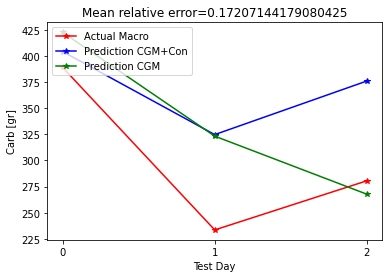

In [4]:
def STMI_XGBoost(trainData,testData,trainLabels,testLabels):
    mseBest=math.inf
    depthBest=float('nan')
    estimatorBest=float('nan')
    modelBest=''

    for numEstimator in np.arange(10,120,10):
        for maxDepth in np.arange(3,10):
            clf = xgb.XGBRegressor(n_estimators =numEstimator,max_depth=maxDepth,objective ='reg:squarederror',eval_metric = "logloss")
            clf.fit(trainData, trainLabels)
            testPrediction = clf.predict(testData)
            mre=[]
            for counter in range(0,len(testPrediction)):
                mre.append(math.fabs(testPrediction[counter]-testLabels[counter])/testLabels[counter])
            mre=np.asarray(mre)
            mre=np.mean(mre)
            if mre<mseBest:
                mreBest=mre
                depthBest=maxDepth
                estimatorBest=numEstimator
                modelBest=clf
                predictionBest=testPrediction
    print(clf.feature_importances_)
    return modelBest,mreBest,predictionBest,depthBest,estimatorBest

def aucCalculator(timeTemp,dataTemp,kernelNumber):
    kernelMeans=np.linspace(0,24,kernelNumber+2)
    kernelMeans=np.delete(kernelMeans,0)
    kernelMeans=np.delete(kernelMeans,-1)
    kernelMeans=kernelMeans*3600

    kernelSTD=2*3600
    aucData=[]
    for kernelMean in kernelMeans:
        kernelTemp=np.exp(-((timeTemp-kernelMean)**2)/(2*kernelSTD**2))
        tempAuc=kernelTemp*dataTemp
        tempAuc=np.trapz(tempAuc,x=timeTemp)
        aucData.append(tempAuc/3600)

    return aucData

def statisticalFeature(timeTemp,dataTemp):
    featureData=[]
    featureList=[]

    featureData.append(np.mean(dataTemp))
    featureData.append(np.max(dataTemp)-np.min(dataTemp))
    featureData.append(np.var(dataTemp))

    featureData.append(np.mean(np.diff(dataTemp,n=1)))
    # featureData.append(np.median(np.diff(dataTemp,n=1)))
    featureData.append(np.max(np.diff(dataTemp,n=1)))
    featureData.append(np.min(np.diff(dataTemp,n=1)))
    # featureData.append(np.var(np.diff(dataTemp,n=1)))

    featureData.append(np.mean(np.diff(dataTemp,n=2)))
    # featureData.append(np.median(np.diff(dataTemp,n=2)))
    # featureData.append(np.max(np.diff(dataTemp,n=2)))
    # featureData.append(np.min(np.diff(dataTemp,n=2)))
    # featureData.append(np.var(np.diff(dataTemp,n=2)))

    featureData.append(np.trapz(dataTemp)/3600)
    return featureData

def featureExtractor(df,contextFlag):
    featureList=[]
    sensors=['CGM','EDA', 'Acc','Temp', 'HR','Cal']


    #-----------------I removed the STEP as it was almost always zero. We should look into it later------------
    featureLabels=[]
    for sensor in sensors:

        varData=df[df['Parameter']==sensor]
        varTime=varData['Time'].tolist()
        varData=varData['Value'].tolist()

        varTime=np.asarray(varTime)
        varData=np.asarray(varData)
        if contextFlag:
            featureList.extend(statisticalFeature(varTime,varData))
            featureLabels.append([sensor,'mean'])
            featureLabels.append([sensor,'max'])
            featureLabels.append([sensor,'var'])
            featureLabels.append([sensor,'S-mean'])
            featureLabels.append([sensor,'S-max'])
            featureLabels.append([sensor,'S-min'])
            featureLabels.append([sensor,'SS-mean'])
            featureLabels.append([sensor,'trapz'])
        if sensor=='CGM':
            featureList.extend(aucCalculator(varTime,varData,9))
            for i in range(0,9):
                featureLabels.append([sensor,'auc'+str(i)])
            featureList.extend(aucCalculator(varTime,varData,6))
            for i in range(0,6):
                featureLabels.append([sensor,'auc'+str(i)])
    print("Used features",featureLabels)
    #REDO IT WITH FITBIT AND E4
    #FOR MEAL TO MEAL PERSPECTIVE, MAKE THE WHOLE DAY INTO 3 CHUNCKS (MEAL TO MEAL)
    #PLOT DAY-DAY VS MEAL TO MEAL AND SHOW THEM HOW WE ARE SEAPRATING THINGS (CGM,EDA,...)

    #https://github.com/fraunhoferportugal/tsfel/tree/9319db4368303cf10adb3aeb72cd4235a8085307
    return featureList

def testTrainSplitFuncAux(dfSensorTemp,dfMacroTemp,contextFlag):
    sensorDataList=[]
    macroDataList=[]
    days=list(set(dfSensorTemp['Date']))

    for day in days:
        dfSensorTempDay=dfSensorTemp[dfSensorTemp['Date']==day]
        sensorDataList.append(featureExtractor(dfSensorTempDay,contextFlag))
        dfMacroTempDay=dfMacroTemp[dfMacroTemp['Date']==day]
        totalCarb=dfMacroTempDay['Carb'].sum()
        totalFat=dfMacroTempDay['Fat'].sum()
        totalProtein=dfMacroTempDay['Protein'].sum()
        macroDataList.append([totalCarb,totalFat,totalProtein])

    return sensorDataList,macroDataList

def featureNormalizer(trainData,testData):
    # repeatingNum=trainData.shape
    # repeatingNum=repeatingNum[0]
    #
    # columnMeans=np.mean(trainData,axis=0)
    # columnMeans = np.repeat(columnMeans[:, np.newaxis], repeatingNum, axis=1)
    # columnMeans=np.transpose(columnMeans)
    # trainData-=columnMeans
    #
    # columnSTD=np.std(trainData,axis=0)
    # columnSTD = np.repeat(columnSTD[:, np.newaxis], repeatingNum, axis=1)
    # columnSTD=np.transpose(columnSTD)
    # trainData/=columnSTD
    #
    # repeatingNum=testData.shape
    # repeatingNum=repeatingNum[0]
    #
    # columnMeans=np.mean(trainData,axis=0)
    # columnMeans = np.repeat(columnMeans[:, np.newaxis], repeatingNum, axis=1)
    # columnMeans=np.transpose(columnMeans)
    # testData-=columnMeans
    #
    # columnSTD=np.std(trainData,axis=0)
    # columnSTD = np.repeat(columnSTD[:, np.newaxis], repeatingNum, axis=1)
    # columnSTD=np.transpose(columnSTD)
    # testData/=columnSTD
    scaler = StandardScaler()
    trainData = scaler.fit_transform(trainData)
    testData = scaler.fit_transform(testData)

    return trainData,testData

def testTrainSplitFunc(dfSensor, dfMacro,randomSeed,contextFlag):
    days=list(set(dfSensor['Date']))
    random.seed(randomSeed)
    random.shuffle(days)
    daysTrain=days[0:6]
    daysTest=days[6:9]

    dfSensorTrain = dfSensor[dfSensor['Date'].isin(daysTrain)]
    dfSensorTest = dfSensor[dfSensor['Date'].isin(daysTest)]

    dfMacroTrain= dfMacro[dfMacro['Date'].isin(daysTrain)]
    dfMacroTest= dfMacro[dfMacro['Date'].isin(daysTest)]

    trainData,trainLabel=testTrainSplitFuncAux(dfSensorTrain,dfMacroTrain,contextFlag)
    testData,testLabel=testTrainSplitFuncAux(dfSensorTest,dfMacroTest,contextFlag)

    trainData=np.asarray(trainData)
    testData=np.asarray(testData)

    trainLabel=np.asarray(trainLabel)
    testLabel=np.asarray(testLabel)

    trainLabel=trainLabel[:,0]
    testLabel=testLabel[:,0]
    trainData,testData=featureNormalizer(trainData,testData)
    # for i in range(0,testData.shape[1]):
    #     plt.figure()
    #     plt.plot(testData[:,i])
    #     plt.title(str(i))
    return trainData,testData,trainLabel,testLabel

randomSeed=random.randrange(100)
trainData,testData,trainLabel,testLabel=testTrainSplitFunc(dfInterp,dfMacro,randomSeed=randomSeed,contextFlag=True)
_,mreCGMCon,predictionCGMCon,_,_=STMI_XGBoost(trainData,testData,trainLabel,testLabel)

trainData,testData,trainLabel,testLabel=testTrainSplitFunc(dfInterp,dfMacro,randomSeed=randomSeed,contextFlag=False)
_,mreCGM,predictionCGM,_,_=STMI_XGBoost(trainData,testData,trainLabel,testLabel)


plt.plot(testLabel,predictionCGM,color='r',label='CGM',)
plt.plot(testLabel,predictionCGM,color='b',label='CGM+Con')

plt.annotate
plt.xlabel('Test Day')
plt.xticks([0,1,2])
plt.ylabel('Carb [gr]')
plt.title('Mean relative error='+str(mreBest))
plt.legend(loc='upper left')